In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import kurtosis, skew
from scipy import stats
import os



In [ ]:
# very 
tau_levels = [0.1, 0.5,0.9]
tau_levels_str = [str(tau).replace('.', '') for tau in tau_levels]
seed_list = [53, 274,1234,89]

base_path = "C:/Users/Attila/Desktop/Attila/Job/Q2C/Q-A2C-Replication/Industry_Expanding_Window/training_outcome/"
dfs = {}

for tau_str in tau_levels_str:
    dfs[tau_str] = {}
    for seed in seed_list:
        folder_name = f"20260508_extended_20y_{seed}_{tau_str}_chunk00"
        file_path = os.path.join(base_path, folder_name, "test_df_with_shares_chunk00.csv")

        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            dfs[tau_str][seed] = df
        else:
            print(f" File not found: {file_path}")

In [12]:
dfs.keys()

dict_keys(['01', '05', '09'])

In [18]:
dfs['05'].keys()

dict_keys([53, 274])

In [13]:
dfs['01'].keys()

dict_keys([53, 1234, 89, 274])

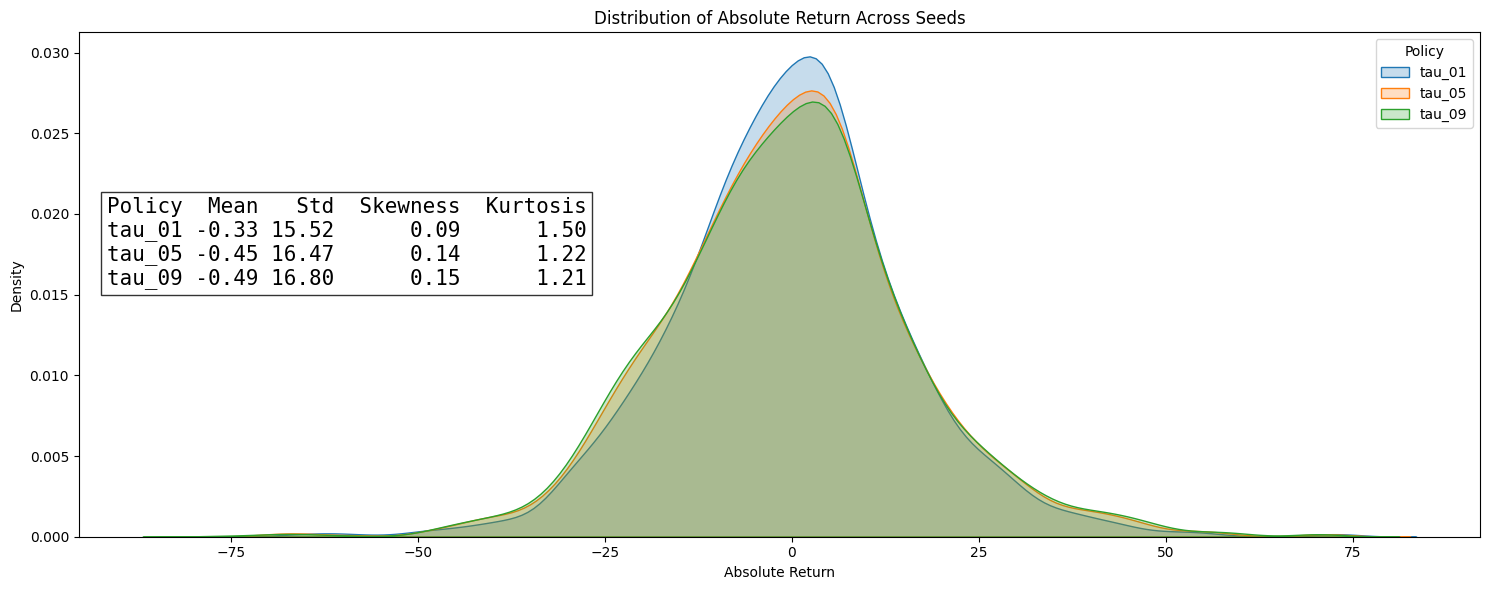

In [3]:
plt.figure(figsize=(15, 6))

stats_list = []

for tau_str in tau_levels_str:
    absolute_returns = []

    for seed, df in dfs[tau_str].items():
        if 'absolute_return' in df.columns:
            absolute_returns.append(df['absolute_return'].values)

    if absolute_returns:
        combined = np.concatenate(absolute_returns)
        sns.kdeplot(combined, label=f'tau_{tau_str}', fill=True)

        # Compute stats
        mean_val = np.mean(combined)
        std_val = np.std(combined)
        skew_val = skew(combined)
        kurt_val = kurtosis(combined)
        stats_list.append([f'tau_{tau_str}', mean_val, std_val, skew_val, kurt_val])

# Add axis labels and title
plt.xlabel('Absolute Return')
plt.ylabel('Density')
plt.title('Distribution of Absolute Return Across Seeds')
plt.legend(title='Policy')

# Add table of statistics
stats_df = pd.DataFrame(stats_list, columns=['Policy', 'Mean', 'Std', 'Skewness', 'Kurtosis'])
stats_text = stats_df.to_string(index=False, float_format=lambda x: f"{x:.2f}")

ax = plt.gca()
ax.text(
    0.02, 0.5, stats_text,
    fontsize=15, family="monospace",
    transform=ax.transAxes,
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
)

plt.tight_layout()
plt.savefig("absolute_return_distribution_stats_stepwise.png", dpi=300, bbox_inches='tight')
plt.show()

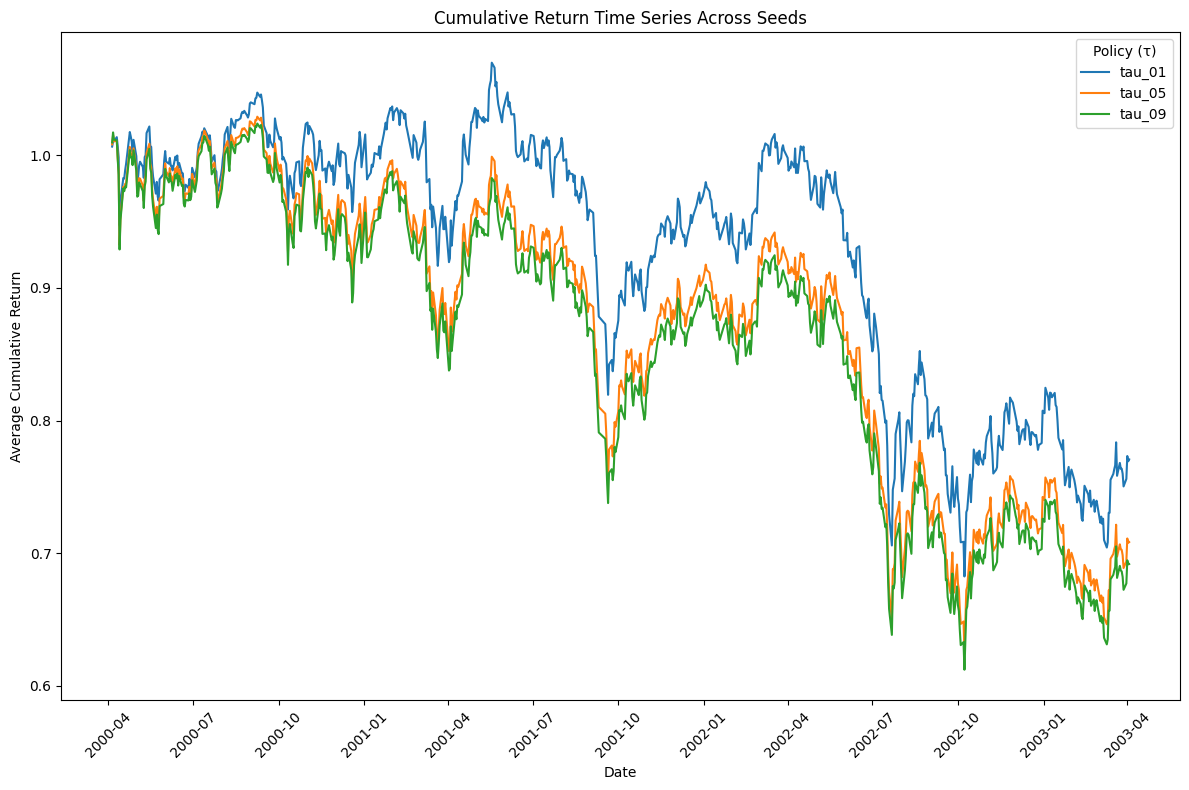

In [4]:
plt.figure(figsize=(12, 8))
ax = plt.gca()

for tau_str in dfs:
    cum_returns_list = []
    date_index = None

    for seed, df in dfs[tau_str].items():
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date')
        if date_index is None:
            date_index = df['date'].values
        cum_returns_list.append(df['cumulative_return'].values)

    avg_cum_return = np.mean(np.stack(cum_returns_list), axis=0)
    plt.plot(date_index, avg_cum_return, label=f'tau_{tau_str}')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))     
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))    

plt.xlabel('Date')
plt.ylabel('Average Cumulative Return')
plt.title('Cumulative Return Time Series Across Seeds')
plt.legend(title='Policy (τ)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("avg_cumulative_returns_stepwise.png", dpi=300, bbox_inches='tight')
plt.show()

In [27]:
tau_to_dfs = {}
for tau, seed_dict in dfs.items():
    for seed, df in seed_dict.items():
        tau_to_dfs.setdefault(tau, []).append(df)

tau_avg_paths = {}
for tau, df_list in tau_to_dfs.items():
    v_columns = [col for col in df_list[0].columns if col.startswith('v_')] # same columns shape
    stacked = np.stack([df[v_columns].values for df in df_list]) # n_seeds, n_steps, n_v_columns
    avg_path = np.mean(stacked, axis=0) # (n_steps, n_v_columns)
    tau_avg_paths[tau] = pd.DataFrame(avg_path, columns=v_columns)

result = pd.DataFrame({
    f"tau_{tau}": df.mean()  
    for tau, df in tau_avg_paths.items()
}).T

result.columns = [f"mean_{col}" for col in result.columns]
result

""
tau_01
tau_05
